In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

In [2]:
%%stata -qui

use "../data/data", clear
rename log_flesch_kincaid_grade_level FKG
quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals  ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

## Logistic Regression

Let ```FKG_01``` be a binary variable indicating that an article's abstract readability is among the 10% highest in the Flesch Kincaid grade level scale.

In [3]:
%%stata -qui
summarize flesch_kincaid_grade_level, detail
local cutoff = r(p90)
gen int FKG_01 = (flesch_kincaid_grade_level >= `cutoff')

In [4]:
%stata list FKG_01 log_num_authors log_num_pages both_genders prop_women jel_flag in 1/10, clean


       FKG_01   log_n~rs   log_~ges   both_g~s   prop_w~n   jel_flag  
  1.        0   .6931472   2.639057          0          0          1  
  2.        1   .6931472    2.70805          0          0          1  
  3.        0   1.098612   3.258096          0          0          1  
  4.        1          0   3.091043          0          0          1  
  5.        1          0   3.496508          0          0          1  
  6.        0          0   2.772589          0          0          1  
  7.        0   1.098612   2.890372          0          0          1  
  8.        1   .6931472   3.295837          0          0          1  
  9.        0   .6931472   2.833213          0          0          1  
 10.        0   .6931472   3.091043          0          0          1  


### Variable Preparation

We now utilize ```Stata``` capabilities to automatically identify ```continuous``` as well as ```dummy``` variables in the data set.

In [5]:
#Cargamos los datos, identifica cuales variables son continuas o discretas o dummy . para eso se usa "set".
#Luego de ejecutar me dice que hay 258 dummy

In [6]:
%%stata
#delimit ;
vl set log_num_authors log_num_pages both_genders prop_women
       `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
       , dummy clear nonotes;
#delimit cr


. #delimit ;
delimiter now ;
. vl set log_num_authors log_num_pages both_genders prop_women
>        `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
>        , dummy clear nonotes;

-------------------------------------------------------------------------------
                  |                      Macro's contents
                  |------------------------------------------------------------
Macro             |  # Vars   Description
------------------+------------------------------------------------------------
System            |
  $vldummy        |     258   0/1 variables
  $vlcategorical  |       0   categorical variables
  $vlcontinuous   |       3   continuous variables
  $vluncertain    |       0   perhaps continuous, perhaps categorical variables
  $vlother        |       0   all missing or constant variables
-------------------------------------------------------------------------------

. #delimit cr
delimiter now cr
. 


We manipulate these variable lists to create two lists of variables: (1) ```baseline``` which contains a mixture of continous as well as dummy variables that we would like to control for, and (2) ```mfe``` which is the list of all other indicator variables that are not of interest but we would like to control for.

In [7]:
#En el modelo X1, X2 y dummy variables, aquí se crea el grupo de 3 variables.
# vl: variable list, una vez que se identificaron las variables, se crea la lista de variables, en el ejemplo yo sé que la mayoría 
## de las variables continuas son las que me interesan
## Tengo una variable dummy que quiero usar como variable de control, prop_ women
## Tengo dos dummys both_genders y jel_flag, que se agruparian con las dummies de efectos fijos en el grupo tres, las saco para ponerlas en el grupo 2.
# La interpretación de los betas cambia si la variable que multiplica es continua o discreta.
## Usar stata para calcular un efecto marginal, se debe especificar la naturaleza del regresor, ejemplo si el regresor es discreto = ,1, se debe especificar porque STATA pernsará que es continuo.
# el "i." a los 257 variables, indica que cada una es un factor (0, 1 ) 
# para creao mfe, se sustituye por i.fe.
# a las variables continuas le extrae Prop_women y crea las variables control, a esas variables control se le suma las dummy, "vl substitute baseline = i.controls_dummy controls" se juntan con este comando.

In [8]:
%%stata -qui
#delimit ;
vl create fe = vldummy - (both_genders jel_flag);
vl substitute mfe = i.fe;
vl create controls = vlcontinuous - (prop_women);
vl create controls_dummy = (both_genders jel_flag);
vl substitute baseline = i.controls_dummy controls; 
vl rebuild;
#delimit cr

In [9]:
%%stata
display "$baseline"
display "$mfe"


. display "$baseline"
i.both_genders i.jel_flag log_num_pages log_num_authors

. display "$mfe"
i.ecm i.jpe i.qje i.res i.a_imp i.b_imp i.c_imp i.e_imp i.f_imp i.g_imp i.h_imp
>  i.i_imp i.j_imp i.k_imp i.l_imp i.m_imp i.n_imp i.o_imp i.p_imp i.q_imp i.r_
> imp i.y_imp i.z_imp i.y_2 i.y_3 i.y_4 i.y_5 i.y_6 i.y_7 i.y_8 i.y_9 i.y_10 i.
> y_11 i.y_12 i.y_13 i.y_14 i.y_15 i.y_16 i.y_17 i.y_18 i.y_19 i.y_20 i.c_2 i.c
> _3 i.c_4 i.c_5 i.c_6 i.c_7 i.c_8 i.c_9 i.c_10 i.c_11 i.c_12 i.c_13 i.c_14 i.c
> _15 i.c_16 i.c_17 i.c_18 i.c_19 i.c_20 i.c_21 i.c_22 i.c_23 i.c_24 i.c_25 i.c
> _26 i.c_27 i.c_28 i.c_29 i.c_30 i.c_31 i.c_32 i.c_33 i.c_34 i.c_35 i.c_36 i.c
> _37 i.c_38 i.c_39 i.c_40 i.c_41 i.c_42 i.c_43 i.c_44 i.c_45 i.c_46 i.c_47 i.c
> _48 i.c_49 i.c_50 i.c_51 i.c_52 i.c_53 i.c_54 i.c_55 i.c_56 i.c_57 i.c_58 i.c
> _59 i.c_60 i.c_61 i.c_62 i.c_63 i.c_64 i.c_65 i.c_66 i.c_67 i.c_68 i.c_69 i.c
> _70 i.c_71 i.c_72 i.c_73 i.c_74 i.c_75 i.c_76 i.c_77 i.c_78 i.c_79 i.c_80 i.c
> _81 i.c_82 i.c_83 i.c

In [10]:
# El objetivo es construir este tipo de comandos, $mfe efecto fijo, no nos interesa, "logit" es el comando que nos permite estimar el parametro beta en regresión logistica.
# vce(cluster cluster) varianza covarianza, para logit, ahora los errores estandar están clusterizados a nivel de sus grados.
# La clusterización afecta la forma qen la que se maximiza, el estimador no convergería al beta verdadero, aún cuando los datos tienen una estimación normal.
# se dice explicitamente que el modelo es miss especificado. , converge a un pseudo parámetro.

In [11]:
%%stata -qui
#delimit ;
logit FKG_01 prop_women $baseline $mfe, vce(cluster cluster) nolog;
#delimit cr

In [ ]:
# en keep va la lista de variables que me interezan. 1.booth_genders importante, star : si el valor p es menor que 0.05 dos estrellitas y así.
# dos estrellitas es el estandar.
# no se puede interpretar el resultado como efectos causales. 
# el signo del Beta informa sobre el cambio de la probabilidad. (el numerito no se considera)

In [12]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders prop_women) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors | -0.2194***  
            log_num_pages |  0.4182***  
           1.both_genders |  0.2597*    
               prop_women | -0.5166**   
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [ ]:
#calcular si la clasificación es ccorrecta.

In [13]:
%stata estat class


Logistic model for FKG_01

              -------- True --------
Classified |         D            ~D  |      Total
-----------+--------------------------+-----------
     +     |        25            16  |         41
     -     |       463          4045  |       4508
-----------+--------------------------+-----------
   Total   |       488          4061  |       4549

Classified + if predicted Pr(D) >= .5
True D defined as FKG_01 != 0
--------------------------------------------------
Sensitivity                     Pr( +| D)    5.12%
Specificity                     Pr( -|~D)   99.61%
Positive predictive value       Pr( D| +)   60.98%
Negative predictive value       Pr(~D| -)   89.73%
--------------------------------------------------
False + rate for true ~D        Pr( +|~D)    0.39%
False - rate for true D         Pr( -| D)   94.88%
False + rate for classified +   Pr(~D| +)   39.02%
False - rate for classified -   Pr( D| -)   10.27%
--------------------------------------------------

### _Average_ Marginal Effects

In [14]:
%%stata
margins, dydx(log_num_authors log_num_pages both_genders prop_women)


Average marginal effects                                 Number of obs = 4,549
Model VCE: Robust

Expression: Pr(FKG_01), predict()
dy/dx wrt:  prop_women 1.both_genders log_num_pages log_num_authors

------------------------------------------------------------------------------
             |            Delta-method
             |      dy/dx   std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
  prop_women |  -.0467823   .0180233    -2.60   0.009    -.0821074   -.0114573
1.both_gen~s |   .0249268   .0110292     2.26   0.024     .0033099    .0465437
log_num_pa~s |   .0378702   .0078389     4.83   0.000     .0225062    .0532342
log_num_au~s |  -.0198674   .0045374    -4.38   0.000    -.0287605   -.0109742
------------------------------------------------------------------------------
Note: dy/dx for factor levels is the discrete change from the base level.


### Marginal Effects

Recall that the base category is an article published in the AER, in the field of 'Microeconomis', in 2000, that belongs to the first cluster. For this type of articles, we are further interested in calculating the marginal effect of the ```prop_women``` among 4 male (```both_genders```=0) co-authors (```log_num_authors```=0.60205999132) at 0, 0.25, 0.5, 0.75, and 1 accross the whole spectrum of articles' length (number of pages).

In [15]:
%%stata -qui
#delimit ;
cd "../data/";
margins, dydx(prop_women) at(prop_women = (0(0.25)1) log_num_pages=(1(0.5)4.5)
                             log_num_authors=0.60205999132 (base) _factor)
                             saving(predictions, replace);
#delimit cr

In [16]:
%%stata -qui
use predictions, clear
rename _at1 prop_women 
rename _at4 log_num_pages
rename _margin delta_hat 
save predictions, replace

In [27]:
# Import the necessary Python packages
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('WebAgg')
import matplotlib.pyplot as plt


# Read (import) the Stata dataset “predictions.dta”
# into a pandas data frame named “data”
data = pd.read_stata("predictions.dta")


# Define a 3-D graph named “ax”
ax = plt.axes(projection='3d')

# Specify the view angle of the graph
ax.view_init(elev=30, azim=200)

# Render the graph
ax.plot_trisurf(data['prop_women'], data['log_num_pages'], data['delta_hat'],cmap=plt.cm.Spectral_r)

# Specify the axis ticks
ax.set_xticks(np.arange(0, 1, step=0.25))
ax.set_yticks(np.arange(1, 4.5, step=0.5))
ax.set_zticks(np.arange( -.1, 0, step=0.02))


# Specify the title and axis titles
ax.set_title("")
ax.set_xlabel("Proportion of Women")
ax.set_ylabel("log(Number of Pages)")
ax.zaxis.set_rotate_label(False)

# Save the graph
plt.savefig("../figures/Margins3d.png")

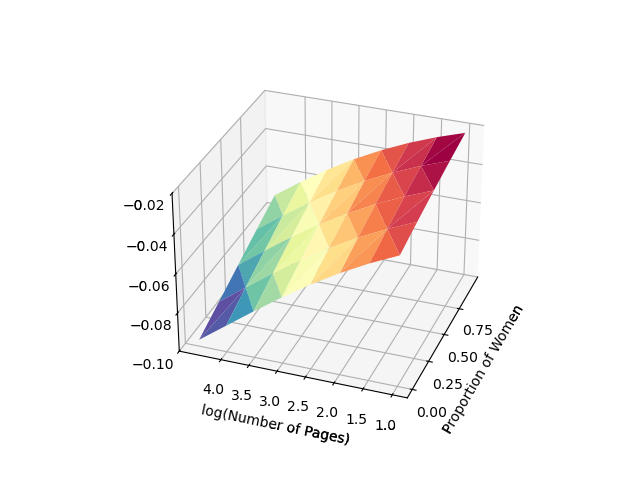

In [29]:
# Showing the graph
from IPython.display import Image
Image("../figures/Margins3d.png")

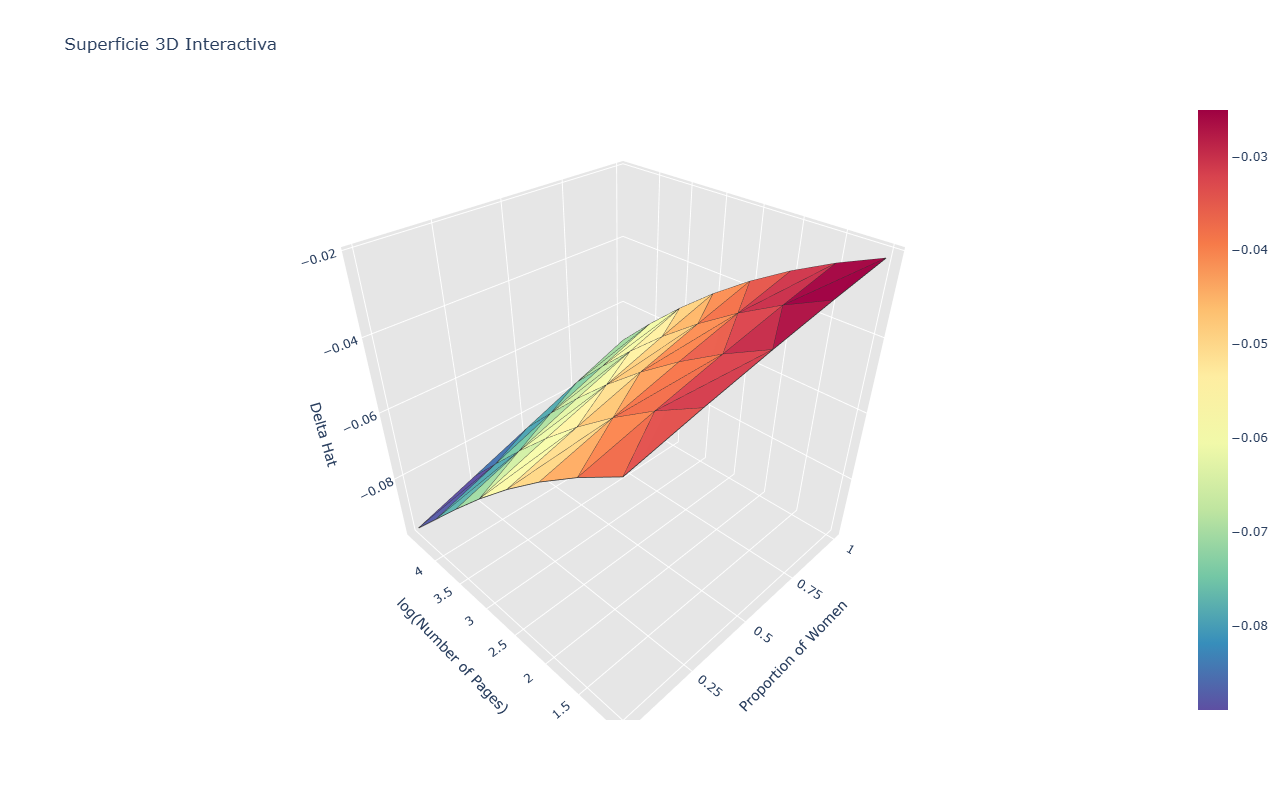

In [37]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Leer el archivo .dta
data = pd.read_stata("predictions.dta")

# Extraer coordenadas
x = data['prop_women'].values
y = data['log_num_pages'].values
z = data['delta_hat'].values

# Generar la triangulación de la superficie
triangles = Delaunay(np.column_stack((x, y))).simplices

# Convertir la escala de 'Spectral' de matplotlib a valores en formato válido para Plotly
colormap = [f"rgb({r*255:.0f},{g*255:.0f},{b*255:.0f})" 
            for r, g, b, _ in plt.cm.Spectral(np.linspace(1, 0, 10))]  # Se invierte la escala

# Crear el gráfico interactivo
fig = ff.create_trisurf(
    x=x,
    y=y,
    z=z,
    simplices=triangles,
    colormap=colormap,
    show_colorbar=True
)

# Personalizar etiquetas y ejes con ticks específicos
fig.update_layout(
    title="Superficie 3D Interactiva",
    scene=dict(
        xaxis=dict(
            title="Proportion of Women",
            tickvals=np.arange(0, 1.25, step=0.25),  # Ticks en X
            autorange="reversed"
        ),
        yaxis=dict(
            title="log(Number of Pages)",
            tickvals=np.arange(1, 4.5, step=0.5),  # Ticks en Y
            autorange="reversed"  # Invertir eje Y
        ),
        zaxis=dict(
            title="Delta Hat",
            tickvals=np.arange(-0.1, 0.02, step=0.02)  # Ticks en Z
        )
    )
)

# Mostrar el gráfico interactivo
fig.show()
